In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import colorsys
import pywt
import random
import os

SAMPLING_RATE = 100 # Hz

def get_device():
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device = get_device()
print(f"Using device: {device}")


def plot_in_time(tensor_array, sampling_rate=SAMPLING_RATE, x_min=-1, y_min=-1, x_max=1, y_max=1, labels=None, plot_size=(700, 500)):
    """
    Plot an array of nx2 PyTorch tensors representing valence-arousal data in an interactive 3D plot using Plotly.
    Each tensor's data is represented by a unique color, with time evolution shown by color opacity.
    
    Args:
    tensor_array (list): A list of PyTorch tensors, each with shape (n, 2).
                         The first column of each tensor represents valence values,
                         the second column represents arousal values.
    sampling_rate (int): The sampling rate of the data in Hz. Default is 100 Hz.
    x_min, y_min, x_max, y_max: The range for x and y axes.
    labels (list): Optional list of labels for each tensor. If None, default labels will be used.
    plot_size (tuple): Size of the plot in pixels (width, height). Default is (800, 600).
    
    Returns:
    None (displays the interactive plot in the default web browser)
    """
    fig = go.Figure()

    num_tensors = len(tensor_array)
    colors = [f"rgb({int(r*255)},{int(g*255)},{int(b*255)})" for r, g, b in 
              [colorsys.hsv_to_rgb(h, 0.8, 0.8) for h in np.linspace(0, 1, num_tensors, endpoint=False)]]

    time_step = 1 / sampling_rate

    for i, tensor in enumerate(tensor_array):
        data = tensor.cpu().numpy()
        
        valence = data[:, 0]
        arousal = data[:, 1]
        
        time = np.arange(len(valence)) * time_step

        base_color = np.array([int(c) for c in colors[i].strip('rgb(').strip(')').split(',')])
        color_array = [f'rgba({base_color[0]},{base_color[1]},{base_color[2]},{0.3 + 0.7 * (t / time[-1])})' for t in time]

        scatter_trace = go.Scatter3d(
            x=valence, y=arousal, z=time,
            mode='lines+markers',
            line=dict(color=colors[i], width=3),
            marker=dict(
                size=2,
                color=color_array,
                opacity=0.8
            ),
            name=labels[i] if labels else f'Tensor {i+1}'
        )
        
        fig.add_trace(scatter_trace)

    fig.update_layout(
        scene=dict(
            xaxis_title='X (Valence)',
            yaxis_title='Y (Arousal)',
            zaxis_title='Time (s)',
            xaxis=dict(range=[x_min, x_max]),
            yaxis=dict(range=[y_min, y_max]),
            aspectmode='manual',
            aspectratio=dict(x=1, y=1, z=0.5)
        ),
        title='Interactive 3D Visualization of Valence-Arousal Data Over Time',
        legend_title_text='Data Series',
        legend=dict(
            itemsizing='constant',
            font=dict(size=10),
            borderwidth=2
        ),
        width=plot_size[0],
        height=plot_size[1]
    )

    fig.show()

def plot_matrix(hidden_state_sequence, num_features_to_plot=None, figsize=(9, 5), title="Plotted Matrix"):
    """
    Plot the evolution of hidden state features over time.
    
    Args:
        hidden_state_sequence (torch.Tensor or np.ndarray): Hidden state sequence of shape (num_time_steps, num_features)
        num_features_to_plot (int, optional): Number of features to plot. If None, all features are plotted.
        figsize (tuple, optional): Figure size (width, height) in inches. Default is (12, 8).
    """
    if isinstance(hidden_state_sequence, torch.Tensor):
        hidden_state_sequence = hidden_state_sequence.cpu().detach().numpy()
    
    num_time_steps, num_features = hidden_state_sequence.shape
    
    if num_features_to_plot is None or num_features_to_plot > num_features:
        num_features_to_plot = num_features
    
    colors = plt.cm.rainbow(np.linspace(0, 1, num_features_to_plot))
    
    plt.figure(figsize=figsize)
    for i in range(num_features_to_plot):
        plt.plot(range(num_time_steps), hidden_state_sequence[:, i], color=colors[i], label=f'Feature {i+1}')
    
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Feature Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()


def load_bitalino_eeg_data(file_path):
    """
    Load EEG data from a file and convert it to two separate PyTorch tensors:
    one for EEG data and one for labels (valence and arousal).
    
    Args:
    file_path (str): Path to the data file.
    
    Returns:
    tuple: (eeg_data, labels)
        eeg_data (torch.Tensor): A timestepsx1 tensor containing the EEG data.
        labels (torch.Tensor): A timestepsx2 tensor where the first column is valence
                               and the second column is arousal.
    """
    try:
        data = np.loadtxt(file_path, delimiter=',')
        
        tensor_data = torch.tensor(data, dtype=torch.float32)
        
        if tensor_data.shape[1] != 3:
            raise ValueError(f"Expected 3 columns, but got {tensor_data.shape[1]}")
        
        eeg_data = tensor_data[:, 0:1]  # First column
        labels = tensor_data[:, 1:3]    # Second and third columns

        eeg_data = eeg_data.to(device)
        labels = labels.to(device)
        
        return eeg_data, labels
    
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    except ValueError as e:
        print(f"Error: Invalid data format - {str(e)}")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
    
    return None, None

def load_multiple_bitalino_eeg_files(folder_path):
    """
    Load EEG data from all files in a given folder using the load_eeg_data_tensor function.
    
    Args:
    folder_path (str): Path to the folder containing the data files.
    
    Returns:
    tuple: (datas_array, labels_array)
        datas_array (list): A list of torch.Tensor, each of shape (timesteps, 1) containing the EEG data.
        labels_array (list): A list of torch.Tensor, each of shape (timesteps, 2) where the first column is valence
                             and the second column is arousal.
    """
    datas_array = []
    labels_array = []
    
    try:
        for filename in os.listdir(folder_path):
            if filename.endswith('.txt'):  # Assuming all data files have .txt extension
                file_path = os.path.join(folder_path, filename)
                
                eeg_data, labels = load_eeg_data(file_path)
                
                if eeg_data is not None and labels is not None:
                    datas_array.append(eeg_data)
                    labels_array.append(labels)
                else:
                    print(f"Warning: Failed to load data from {filename}")
        
        if not datas_array:
            print(f"No valid data files found in {folder_path}")
        else:
            print(f"Successfully loaded {len(datas_array)} data files from {folder_path}")
        
        return datas_array, labels_array
    
    except FileNotFoundError:
        print(f"Error: Folder not found at {folder_path}")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
    
    return [], []

def train_test_split(data_array, labels_array, test_size=0.2, shuffle=True, random_seed=None):
    """
    Split the data and labels into training and validation sets, ensuring each set has at least one element.
    
    Args:
    data_array (list): List of torch.Tensor containing the EEG data.
    labels_array (list): List of torch.Tensor containing the labels.
    test_size (float): Proportion of the dataset to include in the validation split (0.0 to 1.0).
    shuffle (bool): Whether to shuffle the data before splitting.
    random_seed (int): Seed for random number generator to ensure reproducibility.
    
    Returns:
    tuple: (train_data, train_labels, val_data, val_labels)
        train_data (list): List of torch.Tensor containing the training EEG data.
        train_labels (list): List of torch.Tensor containing the training labels.
        val_data (list): List of torch.Tensor containing the validation EEG data.
        val_labels (list): List of torch.Tensor containing the validation labels.
    """
    if len(data_array) != len(labels_array):
        raise ValueError("data_array and labels_array must have the same length")
    
    if len(data_array) < 2:
        raise ValueError("data_array must contain at least 2 elements to perform a split")
    
    if test_size <= 0 or test_size >= 1:
        raise ValueError("test_size must be between 0 and 1")
    
    if random_seed is not None:
        random.seed(random_seed)
        torch.manual_seed(random_seed)
    
    # Create list of indices
    indices = list(range(len(data_array)))
    
    # Shuffle indices if required
    if shuffle:
        random.shuffle(indices)
    
    # Calculate split index, ensuring at least one element in each set
    split_idx = max(1, min(int(len(data_array) * (1 - test_size)), len(data_array) - 1))
    
    # Split indices
    train_indices = indices[:split_idx]
    val_indices = indices[split_idx:]
    
    # Create training and validation sets
    train_data = [data_array[i] for i in train_indices]
    train_labels = [labels_array[i] for i in train_indices]
    val_data = [data_array[i] for i in val_indices]
    val_labels = [labels_array[i] for i in val_indices]
    
    return train_data, train_labels, val_data, val_labels


def accuracy_of_sample(predictions, labels, radius):
    # Ensure both tensors are on the same device
    if predictions.device != labels.device:
        raise ValueError("Predictions and labels must be on the same device")

    differences = torch.abs(predictions - labels) # Calculate the absolute difference between predictions and labels
    within_radius = torch.all(differences <= radius, dim=1) # Check if each sample is within the radius
    accuracy = torch.mean(within_radius.float()) * 100 # Calculate the percentage of samples within the radius

    return accuracy.item()

def accuracy_of_multiple_samples(predictions_array, labels_array, radius):
    
    accuracy = 0
    count = 0
    for predictions in predictions_array:
        sample_accuracy = accuracy_of_sample(predictions, labels_array, radius)
        accuracy += sample_accuracy
        count+=1
    
    return  accuracy/count
    

def pca_pytorch(input, num_components):
    # Ensure input is on the global device
    input = input.to(device)

    # Compute the mean along each feature
    # Shape: [features]
    input_mean = torch.mean(input, dim=0)

    # Center the data by subtracting the mean
    # input_centered shape: [samples, features]
    input_centered = input - input_mean

    # Compute the covariance matrix
    # cov = (input^T * input) / (n-1), where input is centered
    # Shape: [features, features]
    cov = torch.mm(input_centered.t(), input_centered) / (input.shape[0] - 1)

    # Compute eigenvalues and eigenvectors of the covariance matrix
    # eigenvalues: [features], eigenvectors: [features, features]
    eigenvalues, eigenvectors = torch.linalg.eigh(cov)

    # Sort eigenvectors by descending eigenvalues
    # idx contains indices for sorting
    idx = torch.argsort(eigenvalues, descending=True)
    # Reorder eigenvectors based on sorted indices
    eigenvectors = eigenvectors[:, idx]

    # Select top k eigenvectors (principal components)
    # Shape: [features, num_components]
    components = eigenvectors[:, :num_components]

    # Project the centered data onto the principal components
    # input_pca = input_centered * components
    # Shape: [samples, num_components]
    input_pca = torch.mm(input_centered, components)

    return input_pca, components, input_mean

def apply_pca(new_input, pca_components, data_mean):
    
    new_input = new_input.to(pca_components.device) # Ensure new_input is on the same device as pca_components and data_mean
    new_input_centered = new_input - data_mean # Center the new input
    new_input_pca = torch.mm(new_input_centered, pca_components) # Project the centered data onto the principal components

    return new_input_pca

def multiple_pca(datas_array, top_n_PCs):
    null_array, pca_components, data_mean = pca_pytorch(datas_array[0], top_n_PCs)
    for data in datas_array:
        data = apply_pca(data, pca_components, data_mean) # assumed all data has the same mean but good enough for now
    
    return datas_array

def uwt(eeg_tensor, levels=5, normalize=True):
    
    assert len(eeg_tensor.shape) == 2 and eeg_tensor.shape[1] == 1, "Input should be a [n, 1] tensor"
    
    device = eeg_tensor.device # Store the device of the input tensor
    eeg_np = eeg_tensor.cpu().numpy().flatten() # Move input to CPU for numpy operations
    
    # wavelet = pywt.Wavelet('db4')
    wavelet = pywt.Wavelet('db20')
    # wavelet = pywt.Wavelet('gaus')
    # print(pywt.wavelist())
    dec_lo, dec_hi, _, _ = wavelet.filter_bank
    
    pad_len = (len(dec_lo) - 1) * (2**levels)
    eeg_padded = np.pad(eeg_np, (pad_len, pad_len), mode='reflect')
    
    detail_coeffs = []
    
    approx = eeg_padded
    for i in range(levels):
        filter_len = len(dec_lo) * (2**i)
        lo = np.zeros(filter_len)
        hi = np.zeros(filter_len)
        lo[0::2**i] = dec_lo
        hi[0::2**i] = dec_hi
        
        detail = np.convolve(approx, hi, mode='same')
        approx = np.convolve(approx, lo, mode='same')
        
        if normalize:
            detail = detail / np.sqrt(2**i)
        
        detail_coeffs.append(detail[pad_len:-pad_len])
    
    approx_coeffs = approx[pad_len:-pad_len]
    if normalize:
        approx_coeffs = approx_coeffs / np.sqrt(2**levels)
    
    # Convert to PyTorch tensors and move to the original device
    gamma = torch.tensor(detail_coeffs[0], device=device).view(-1, 1).float()
    beta = torch.tensor(detail_coeffs[1], device=device).view(-1, 1).float()
    alpha = torch.tensor(detail_coeffs[2], device=device).view(-1, 1).float()
    theta = torch.tensor(detail_coeffs[3], device=device).view(-1, 1).float()
    delta = torch.tensor(approx_coeffs, device=device).view(-1, 1).float()
    
    return gamma, beta, alpha, theta, delta

def multiple_uwt(datas_array, levels=5, normalize=True):
    combined_array = []
    for data in datas_array:
        data_g, data_b, data_a, data_t, data_d = uwt(eeg_tensor=data, levels=levels, normalize=normalize)
        combined = torch.cat((data, data_g, data_b, data_a, data_t, data_d), dim=1)
        combined_array.append(combined)
        
    return combined_array



class MLP(nn.Module):
    def __init__(self, neuron_layers):
        super(MLP, self).__init__()
        
        if len(neuron_layers) < 2:
            raise ValueError("At least input and output layer sizes must be specified")
        
        self.layers = nn.ModuleList()
        for i in range(len(neuron_layers) - 1):
            self.layers.append(nn.Linear(neuron_layers[i], neuron_layers[i+1], bias=True))
    
    def to(self, device):
        super(MLP, self).to(device)
        return self
    
    def forward(self, x):
        x = x.to(device)
        # x shape: [samples, features]
        for i, layer in enumerate(self.layers):
            x = layer(x)
            x = F.tanh(x)
        return x  # Return shape: [samples,  outputs]
    
    def create_outputs_sequence(self, hidden_state_sequence):
        hidden_state_sequence = hidden_state_sequence.to(device)
        with torch.no_grad():
            return self.forward(hidden_state_sequence)
    
    def train_model(self, training_data, labels, optimizer, criterion, epochs):
        # clear_cuda_cache()
        training_data = training_data.to(device)
        labels = labels.to(device)
        
        training_data = training_data.detach()
        labels = labels.detach()
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = self(training_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if epoch % 1 == 0:
                print(f'[Epoch {epoch + 1}] loss: {loss.item():.5f}')

        print('Finished Training')
        
    def advanced_train_model(self, datas_array, labels_array, optimizer, criterion, epochs):
        datas_array = [data.to(device) for data in datas_array]
        labels_array = [label.to(device) for label in labels_array]
        
        combined_data = torch.cat(datas_array, dim=0)
        combined_labels = torch.cat(labels_array, dim=0)

        for epoch in range(epochs):
            num_samples = combined_data.shape[0]
            perm = torch.randperm(num_samples)

            shuffled_data = combined_data[perm]
            shuffled_labels = combined_labels[perm]
            
            optimizer.zero_grad()
            
            outputs = self(shuffled_data)            
            loss = criterion(outputs, shuffled_labels)
            loss.backward()
            
            # # Divide gradients by the batch size (full batch)
            # for param in self.parameters():
            #     if param.grad is not None:
            #         param.grad / combined_data.shape[0]
        
            optimizer.step()

            if epoch % 1 == 0:
                print(f'[Epoch {epoch + 1}] loss: {loss.item():.5f}')

        print('Finished Advanced Training')

class LTC(nn.Module):
    def __init__(self, LTC_layers):
        super(LTC, self).__init__()
        
        # self.activation = nn.Sigmoid()
        self.activation = nn.Tanh()
        
        self.layers = nn.ModuleList()
        
        # Initialize LTC layers without gradients
        for i in range(len(LTC_layers) - 1):
            layer = nn.Linear(LTC_layers[i], LTC_layers[i+1], bias=True)
            layer.weight.requires_grad = False
            layer.bias.requires_grad = False
            self.layers.append(layer) 
        
        
    def forward(self, input, hidden):
        hidden = hidden.view(-1, self.layers[-1].out_features)
        
        combined = torch.cat((input, hidden), dim=1)
        
        # # pass the row through the ltc layers
        for layer in self.layers:
            combined = layer(combined)
            combined = self.activation(combined)
            
        return combined


    def create_hidden_state_sequence(self, training_example, tau, A, step_size):
        training_example = training_example.to(device)
        
        with torch.no_grad():
            sequence_length = training_example.shape[0]
            hidden_state_sequence = torch.zeros(sequence_length + 1, self.layers[-1].out_features, device=device)
            
            for i in range(sequence_length):
                
                input = training_example[i:i+1, :]
                hidden_state = hidden_state_sequence[i:i+1, :]
                
                ltc_output = self.forward(input, hidden_state)
                
                # Euler method
                # DxOnDt = -x(t)/Tau + Y(A - x(t))
                # first_term = - hidden_state / tau
                # second_term = ltc_output * (A - hidden_state)
                # DxOnDt = first_term + second_term
                # hidden_state_sequence[i+1:i+2, :] += hidden_state + DxOnDt * step_size
                
                # Fused step
                num = hidden_state + step_size * ltc_output * A
                den = 1 + step_size * (1/tau + ltc_output)
                hidden_state_sequence[i+1:i+2, :] += num / den
                
                
            return hidden_state_sequence[1:, :]

Using device: cuda:0


Successfully loaded 3 data files from D:\Programming\Python\EEGStuff\DataSamples


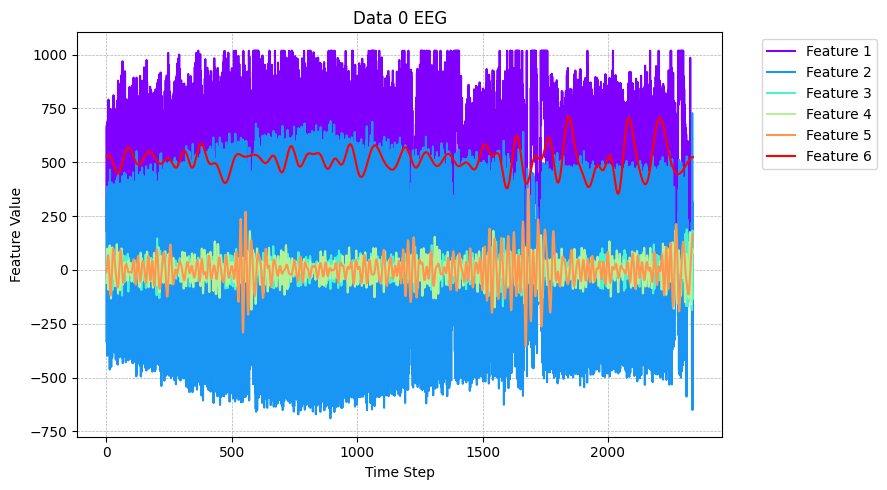

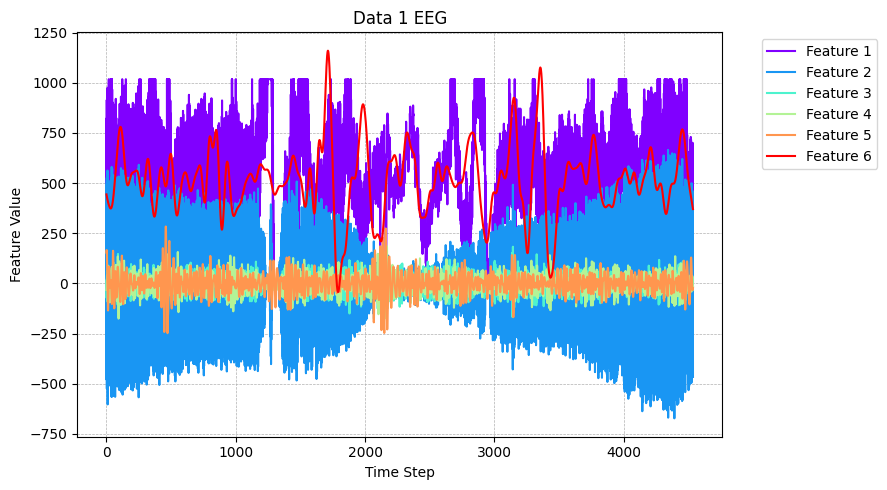

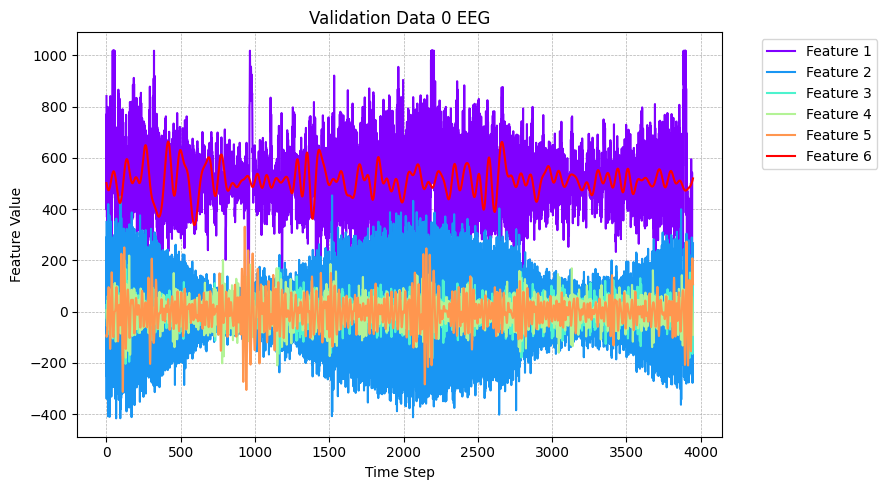

In [105]:

ggaht_data, ggaht_labels = load_bitalino_eeg_data(r"D:\Programming\Python\EEGStuff\DataSamples\GGAHTTest.txt")
tin_data, tin_labels = load_bitalino_eeg_data(r"D:\Programming\Python\EEGStuff\DataSamples\TINTest.txt")
thai_data, thai_labels = load_bitalino_eeg_data(r"D:\Programming\Python\EEGStuff\DataSamples\THAITest.txt")

datas_array, labels_array = load_multiple_bitalino_eeg_files(r"D:\Programming\Python\EEGStuff\DataSamples")

datas_array = multiple_uwt(datas_array)

datas_array = multiple_pca(datas_array, top_n_PCs=3)
    
datas_array, labels_array, val_datas_array, val_labels_array = train_test_split(datas_array, labels_array, test_size=0.1, shuffle=True, random_seed=8)

for i, data in enumerate(datas_array):
    plot_matrix(data, title=f"Data {i} EEG",)
    
for i, data in enumerate(val_datas_array):
    plot_matrix(data, title=f"Validation Data {i} EEG",)

In [106]:
hidden_state_features = 10
input_features = datas_array[0].shape[1]
output_features = labels_array[0].shape[1]

ltc = LTC([hidden_state_features + input_features, hidden_state_features, hidden_state_features]).to(device)

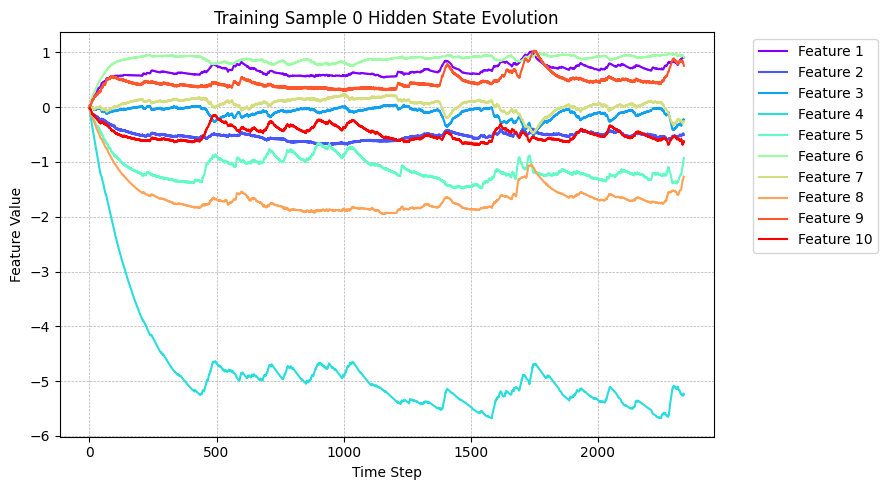

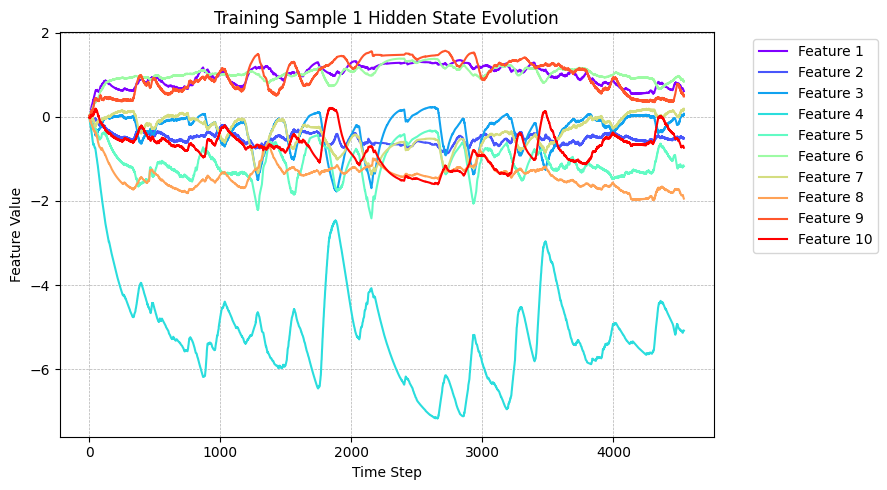

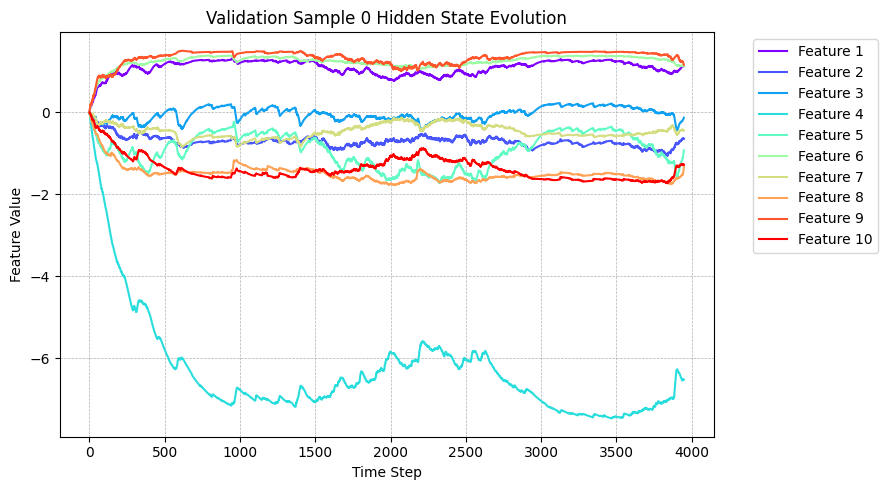

In [107]:
T = 0.8
AY = 4
S = 1/SAMPLING_RATE

hidden_state_sequence_array = []
val_hidden_state_sequence_array = []

for data in datas_array:
    hidden_state_sequence_array.append(ltc.create_hidden_state_sequence(data, tau=T, A=AY, step_size=S))
    
for val_data in val_datas_array:
    val_hidden_state_sequence_array.append(ltc.create_hidden_state_sequence(val_data, tau=T, A=AY, step_size=S))
    

for i, hidden_state_sequence in enumerate(hidden_state_sequence_array):
    plot_matrix(hidden_state_sequence, title=f"Training Sample {i} Hidden State Evolution")
    
for i, val_hidden_state_sequence in enumerate(val_hidden_state_sequence_array):
    plot_matrix(val_hidden_state_sequence, title=f"Validation Sample {i} Hidden State Evolution")    

In [108]:
mlp = MLP([hidden_state_features, hidden_state_features, output_features]).to(device)

# criterion = nn.CrossEntropyLoss() # Interestingly, doesn't work with single input, single output network
criterion = nn.MSELoss()

# optimizer = optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adadelta(mlp.parameters(), lr=0.01)
optimizer = optim.Adamax(mlp.parameters(), lr=0.05) # best optimizer thus far
# optimizer = optim.Adam(mlp.parameters(), lr=0.01)

In [109]:
outputs_before_array = []
val_outputs_before_array = []

for hidden_state_sequence in hidden_state_sequence_array:
    outputs_before_array.append(mlp.create_outputs_sequence(hidden_state_sequence))
    
for val_hidden_state_sequence in val_hidden_state_sequence_array:
    val_outputs_before_array.append(mlp.create_outputs_sequence(val_hidden_state_sequence))


In [110]:
mlp.advanced_train_model(hidden_state_sequence_array,
                        labels_array,
                        optimizer=optimizer,
                        criterion=criterion,
                        epochs=10000)

[Epoch 1] loss: 0.74186
[Epoch 2] loss: 0.19596
[Epoch 3] loss: 0.25852
[Epoch 4] loss: 0.27959
[Epoch 5] loss: 0.23625
[Epoch 6] loss: 0.20137
[Epoch 7] loss: 0.19084
[Epoch 8] loss: 0.18933
[Epoch 9] loss: 0.18962
[Epoch 10] loss: 0.19369
[Epoch 11] loss: 0.19524
[Epoch 12] loss: 0.18852
[Epoch 13] loss: 0.17870
[Epoch 14] loss: 0.17248
[Epoch 15] loss: 0.17163
[Epoch 16] loss: 0.17391
[Epoch 17] loss: 0.17660
[Epoch 18] loss: 0.17795
[Epoch 19] loss: 0.17736
[Epoch 20] loss: 0.17510
[Epoch 21] loss: 0.17194
[Epoch 22] loss: 0.16887
[Epoch 23] loss: 0.16669
[Epoch 24] loss: 0.16577
[Epoch 25] loss: 0.16585
[Epoch 26] loss: 0.16631
[Epoch 27] loss: 0.16642
[Epoch 28] loss: 0.16577
[Epoch 29] loss: 0.16436
[Epoch 30] loss: 0.16251
[Epoch 31] loss: 0.16065
[Epoch 32] loss: 0.15906
[Epoch 33] loss: 0.15783
[Epoch 34] loss: 0.15686
[Epoch 35] loss: 0.15595
[Epoch 36] loss: 0.15498
[Epoch 37] loss: 0.15388
[Epoch 38] loss: 0.15266
[Epoch 39] loss: 0.15140
[Epoch 40] loss: 0.15018
[Epoch 41

In [111]:
accuracy_radius = 0.1

outputs_after_array = []
val_outputs_after_array = []

for hidden_state_sequence in hidden_state_sequence_array:
    outputs_after_array.append(mlp.create_outputs_sequence(hidden_state_sequence))
    
for val_hidden_state_sequence in val_hidden_state_sequence_array:
    val_outputs_after_array.append(mlp.create_outputs_sequence(val_hidden_state_sequence))

# for i in range(len(datas_array)):
#     print(accuracy_of_sample(outputs_after_array[i], labels_array[i], accuracy_radius))
#     plot_in_time([outputs_before_array[i], labels_array[i], outputs_after_array[i]],
#             labels=[f"Sample {i} Before training", f"Sample {i} Labels", f" Sample {i} After"])
    
for i in range(len(val_datas_array)):
    print(accuracy_of_sample(val_outputs_after_array[i], val_labels_array[i], accuracy_radius))
    plot_in_time([val_outputs_before_array[i], val_labels_array[i], val_outputs_after_array[i]],
            labels=[f"Validation Sample {i} Before training", f"Validation Sample {i} Labels", f"Validation Sample {i} After"])

2.2784810066223145
